#Лабораторная работа 1
#"Алгоритмы разложения матриц. PCA"

Цель работы: Использование методов матричного разложения в алгоритмах обработки данных (метода главных компонент).

## Содержание:


**0.   Использованные библиотеки**

**1.   SVD**

**2. Kernel PCA**

**3. Вывод**

**4. Список литературы**



##0. Использованные библиотеки

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import to_categorical
from sklearn.decomposition import PCA


##1. SVD

###1.1 Краткая теория о сингулярном разложении

  Любую матрицу можно представить в виде произведения:
  A = UΣVᵀ, где U, V - ортогональные матрицы, Σ - матрица с сингулярными значениями. [1]


Пусть 𝛌 - собственное значение, σ - сингулярное значение, тогда:

    σ = √𝛌.
Таким образом, задача нахождения сингулярного разложения матрицы сводится к решению задачи на собственные значения для матриц A*Aᵀ или Aᵀ*A.


---


Для решения задачи на собственные значения существуют разные методы и подходы. Так, предлагаемый методическим руководством метод Грамма-Шмидта считается одним из простых в реализации алгоритмов, однак обладает значительной численной неустойчивостью в сравнении с остальными[2]. Поэтому, в данной лабораторной работе был использован QR алгоритм на основе отражений Хаусхолдера.

QR разложение представляет собой итерационный алгоритм, на каждой итерации которого вычисляется матрица Хаусхолдера H такая, что

$ H = I - βvvᵀ $,     где $ β = 2 / (vᵀv)$ [3]

такая, что при умножении $ H_i$ на матрицу А обнуляются поддиагональные элементы $i$-го столбца. В конце алгоритма матрица А принимает вид верхнетреугольной матрицы, соответствующей R, а матрица Q получается путем перемножения вычесленных на каждой итерации матриц Н:

$Q = H_1H_2H_3...H_i$. [3]


Очевидно, что данный наивный алгоритм обладает двумя существенными недостатками:


1.   Алгоритм обладает значительной вычислительной сложностью, оцениваемый порядком $O(n^3)$, что приводит к кубическому росту временных затрат при увеличении размера матрицы.
2.   Для вычисления матрицы Q необходимо хранить все матрицы Н с каждой итерации.



Поэтому Ван Лоаном было предложен следующее - любую матрицу Q можно представить в таком виде, что:
$Q = I - WY^T$ [4]

где Y - матрица, содержащая вектора отражения, W - матрица $m*n$. Теперь, для вычисления матрицы Q требуется всего одно матричное отражение, а благодаря рекуррентному формированию матриц W и Y для хранения требуется всего две матрицы.

Можно заметить, что и данный алгоритм все еще не является достаточно оптимальным, так как размер матрицы W - m∗n, что достаточно затратно для матриц больших размерностей. Поэтому, следующим шагом стало представление матрицы Q в виде

$Q = I - YTY^T$ [5]

где Y все та же матрица с векторами отражения, а матрица T - верхнетреугольная матрица размера n∗n. Таким образом, данное представление, называемое CompactWY, позволяет хранить матрицу Q еще более эффективно. Именно этот подход и был реализован в данной работе. Стоит также отметить, что метод CompactWY используется в библиотеке для решения задач линейной алгебры LAPACK, что говорит о практической ценности выбранного нами подхода.

###1.2 Практическая реализация

In [ ]:
def sign(x): # функция для определения знака
    if x > 0:
        return 1
    elif x < 0:
        return -1
    else:
        return 0

In [ ]:
def norma(v):
    return sum(map(lambda y: y ** 2, v)) ** 0.5 # Норма: корень из суммы квадратов элементов

In [ ]:
def breakpoint(A): # вычисляет значение для точки останова (работает только с первой поддиагональю)
    m, n = A.shape
    res = 0
    for i in range(1, n):
        res += abs(A[i, i-1])
    return res

In [ ]:
def Z(T, Y, v): # вычисляет вектор z для QR разложения
    return (T @ (Y.T @ v)).flatten()

In [ ]:
def reflecting_vector(x, n): # вычисление вектора отражения
    v = np.zeros_like(x)
    v_end = x[n:].copy() # Оптимизация - работаем не со всем вектором, а только с его концом (начиная с диагонального элемента и ниже)
    if norma(v_end) == 0:
        return v
    v_end[0] = v_end[0] + sign(v_end[0])*norma(v_end) # обработка диагонального элемента

    v_norm = norma(v_end) # вычисляем норму по реализованной функции

    if v_norm != 0:
        v_end = v_end / v_norm # нормируем вектор

    v[n:] = v_end
    return v

In [ ]:
def QR_factorization(block): # QR разложение
    m, n = block.shape
    start_indx = 0
    T = np.array([])
    Y = np.array([]).reshape(m, 0)

    for j in range(n):
        # Берем j-й столбец
        x = block[:, j].copy()

        # Вычисляем вектор Хаусхолдера для этого столбца
        v = reflecting_vector(x, start_indx + j).reshape(-1, 1)


        beta = 2.0 # Всегда 2, так как векторы нормализованы (бета = 2 / (vT * v), vT * v дадут скаляр, так как нормированы, то 1)

        # Применяем преобразование Хаусхолдера ко всем столбцам
        for i in range(j, n):
            v_dot_col = np.dot(v.flatten(), block[:, i])
            block[:, i] = block[:, i] - beta * v_dot_col * v.flatten()

        # Обновляем compact WY представление
        if T.size == 0:
            T = np.array([[beta]])
            Y = v
        else:
            # Вычисляем w = T_block * (Y_block^T * v)
            z = Z(T, Y, v)

            # Расширяем T_block
            k = T.shape[0]
            tmp = np.zeros((k + 1, k + 1))
            tmp[:k, :k] = T
            tmp[:k, k] = -beta * z
            tmp[k, k] = beta
            T = tmp

            # Расширяем Y_block
            Y = np.column_stack((Y, v))

    return T, Y, block # В Y - все векторы отражения, в T - то, как эти вектора взаимодействуют(очень грубое объяснение)

In [ ]:
def direct_conversion(T, Y, R): # Это обратное применение разложения - R * Q
    RQ = R - (R @ Y) @ (T @ Y.T)

    return RQ

In [ ]:
def QR_algoritm(matrix, iter=100):
    A = matrix.copy()
    # Если успею, добавлю преведение к форме Хессенберга
    for step in range(iter):
        T, Y, R = QR_factorization(A) # Сначала делаем наше QR разложение - получаем Q(Q = I-Y*T*Y.T) и R
        A_next = direct_conversion(T, Y, R) #Получаем новую матрицу R * Q
        if breakpoint(A_next) < 0.001: # Делаем до тех пор, пока матрица не перестанет изменяться
            return A_next
        A = A_next
    return A

In [ ]:
def reverse_iterations(matrix, eigenvalues, iters = 100): # Метод обратных итераций для поиска собственных векторов
    A = matrix.copy()
    m, n = A.shape
    E = np.eye(m)
    result = []
    for val in eigenvalues:
        u = np.random.randn(m, 1)
        u = u / norma(u)
        for i in range(iters):
            y = np.linalg.solve(A - val * E, u) # Это решение систем уравнений, реализую в ручную, если успею к дедлайну
            y_norm = norma(y)
            if y_norm < 0.00001:  # Избегаем деления на 0
                y = np.random.randn(m, 1)
                y = y / norma(y)
            else:
                y = y / y_norm

            if norma(y - u) < 0.001:
                break
            u = y
        result.append(y)

    return np.column_stack(result)


In [ ]:
def SVD(matrix, view="vector"):  # Само сингулярное разложение
    A = matrix.copy()
    m, n = A.shape

    Av = A.T @ A  # Находим правые вектора
    Av_QR = QR_algoritm(Av)
    eigenvaluesR = np.diag(Av_QR)
    eigenvaluesR = np.sort(eigenvaluesR)[::-1]
    eigenvaluesR = np.where(eigenvaluesR < 1e-10, 0, eigenvaluesR)
    V = reverse_iterations(Av, eigenvaluesR)


    Au = A @ A.T  # Находим левые вектора
    Au_QR = QR_algoritm(Au)
    eigenvaluesL = np.diag(Au_QR)
    eigenvaluesL = np.sort(eigenvaluesL)[::-1]
    eigenvaluesL = np.where(eigenvaluesL < 1e-10, 0, eigenvaluesL)
    U = reverse_iterations(Au, eigenvaluesL)

    if m >= n:
        eigenvalues = eigenvaluesR
    else:
        eigenvalues = eigenvaluesL
    singular = np.sqrt(eigenvalues)  # Сингулярные значения - это корни из собственных значений (те самые, которые ищет QR алгоритм)
    singular_values = np.zeros((m, n))  # Размер матрицы Sigma равен (m, n)
    np.fill_diagonal(singular_values, singular)

    for i in range(min(m, n)):
        # Нормализуем знак по максимальному по модулю элементу
        max_idx = np.argmax(np.abs(U[:, i]))
        if U[max_idx, i] < 0:
            U[:, i] = -U[:, i]
            V[:, i] = -V[:, i]
    if view == "matrix":
        S_diag = singular_values # view позволяет выбрать, в каком виде функция вернет сингулярное разложение
    else:
        S_diag = np.diag(singular_values)
    #S_diag = singular_values # изначально возвращало полноразмерную матрицу, но для совместимости с KPCA пришлось переделать, чтобы возвращались только
                              # сингулярные значения
    return U, S_diag, V

In [ ]:
def explicable_variance(S): # Функция, вычисляющая объяснимые дисперсии
    total = np.sum(S ** 2)
    per_comp = S ** 2
    return per_comp / total

Обучим нейронную сеть на открытом датасете с оценкой качества сортов красного вина. Исходный датасет содержит 11 признаков

        1. Fixed acidity
        2. Volatile acidity
        3. Citric acid
        4. Residual sugar
        5. Chlorides
        6. Free sulfur dioxide
        7. Total sulfur dioxide
        8. Density
        9. pH
        10. Sulphates
        11. Alcohol
        Таргет - Quality (score between 0 and 10)





In [ ]:
# Загрузка датасета
data = pd.read_csv('wine_red.csv', delimiter=";")
data = data.sample(n=300, random_state=42)

X = data.drop('quality', axis=1)
y = data['quality']

# Кодируем метки для многоклассовой классификации
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"Уникальные классы: {np.unique(y)}")  # Проверим сколько классов
print(f"Закодированные классы: {np.unique(y_encoded)}")
y_categorical = to_categorical(y_encoded)

# ВАЖНО: определяем количество классов динамически
num_classes = len(le.classes_)
print(f"Количество классов: {num_classes}")

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Масштабирование данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Создание модели ИНС для многоклассовой классификации
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.1))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(num_classes, activation='softmax'))  # Динамическое количество классов

# Компиляция модели
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Обучение модели
history = model.fit(X_train, y_train, epochs=300, batch_size=32, validation_data=(X_test, y_test))

y_pred_prob = model.predict(X_test)
y_pred = y_pred_prob.argmax(axis=1)  # Берем класс с максимальной вероятностью
y_true = y_test.argmax(axis=1)

# Вычисление F1-меры
f1 = f1_score(y_true, y_pred, average='macro')
print(f'F1 Score: {f1:.4f}')

Уникальные классы: [3 4 5 6 7 8]
Закодированные классы: [0 1 2 3 4 5]
Количество классов: 6
Epoch 1/300


C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.1708 - loss: 1.7510 - val_accuracy: 0.5000 - val_loss: 1.5598
Epoch 2/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4750 - loss: 1.5248 - val_accuracy: 0.5500 - val_loss: 1.3561
Epoch 3/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5292 - loss: 1.3549 - val_accuracy: 0.5667 - val_loss: 1.1956
Epoch 4/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5125 - loss: 1.2285 - val_accuracy: 0.4833 - val_loss: 1.0964
Epoch 5/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5375 - loss: 1.1275 - val_accuracy: 0.5333 - val_loss: 1.0441
Epoch 6/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5708 - loss: 1.0798 - val_accuracy: 0.5000 - val_loss: 1.0300
Epoch 7/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5667 - loss: 1.0322 - val_accuracy: 0.4667 - val_loss: 1.0235
Epoch 8/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5833 - loss: 1.0030 - val_accuracy: 0.4500 - val_loss: 1.0197
Epoch 9/300

In [ ]:
wine = scaler.fit_transform(X) # нормализуем признаки

In [ ]:
U, S, V = SVD(wine, "matrix") # вычисляем SVD

In [ ]:
print("Матрицы преобразования данных к главным компонентам:")
print(V)
print("Объясняемая дисперсия:")
print(np.diag(explicable_variance(S)))

[[ 0.49458376  0.10464336 -0.01253189  0.23844044  0.06433503 -0.05199061
  -0.34385797 -0.18313794  0.16253944  0.28973861 -0.64686817]
 [-0.27467509 -0.14039822 -0.44174858  0.06483425  0.34156773  0.18073496
  -0.64257646 -0.03792606 -0.14741442 -0.34593212 -0.02049581]
 [ 0.44328717  0.09285705  0.30619161  0.02040211 -0.10091439  0.03305716
  -0.01833785 -0.2818267  -0.53153194 -0.57031382  0.04337511]
 [ 0.13037069 -0.4166823   0.13396114  0.26514622  0.66498859  0.12143967
   0.4278668   0.14874296  0.08806217 -0.17589749 -0.14242358]
 [ 0.2061982  -0.06663712 -0.33752248 -0.57043015  0.04301461  0.55255419
   0.24090588 -0.36431479  0.04812517  0.09452207 -0.06746904]
 [-0.02575645 -0.56960108  0.24646317 -0.13446104 -0.26771239 -0.15307041
  -0.18729953 -0.32107917  0.5338894  -0.27816315  0.01952691]
 [ 0.02653337 -0.62587481  0.15116253 -0.09496824 -0.1638963   0.09014327
  -0.17116938  0.19297722 -0.53275437  0.43390546 -0.04560139]
 [ 0.39903166 -0.14617423 -0.37445869  0.

Из вычисленных объясняемых дисперсий видно, что достаточным является 5 компонент

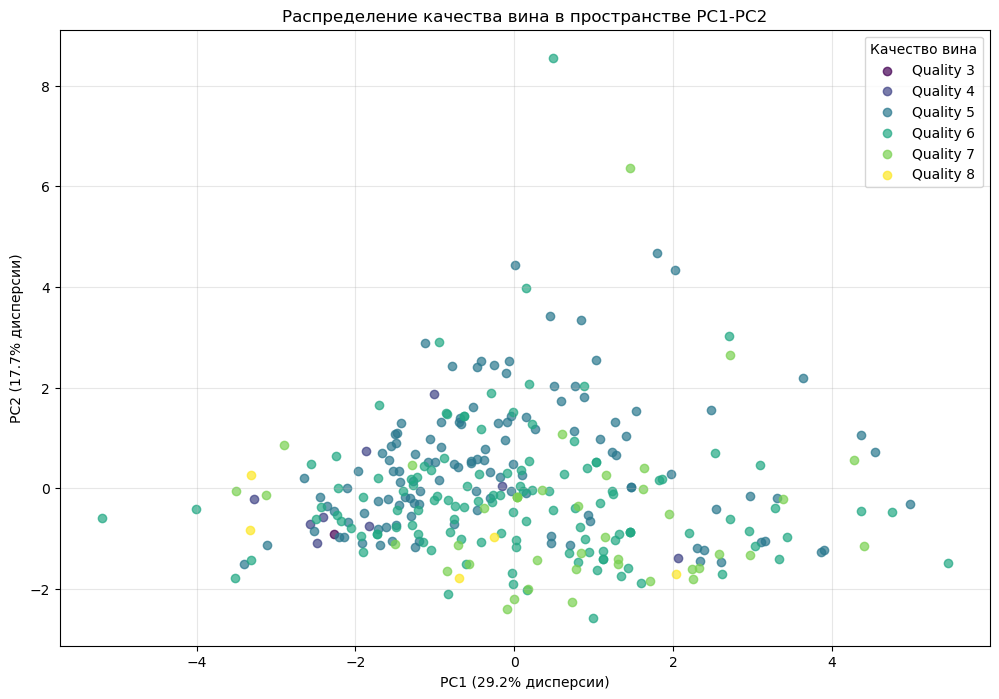

In [ ]:
winePCA = U @ S
winePCA = winePCA[:, :2]
# Создаем цветовую карту для дискретных значений
unique_qualities = np.unique(y)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_qualities)))

plt.figure(figsize=(12, 8))
for i, quality in enumerate(unique_qualities):
    mask = (y == quality)
    plt.scatter(winePCA[mask, 0], winePCA[mask, 1],
               c=[colors[i]], label=f'Quality {quality}', alpha=0.7)

plt.xlabel('PC1 (29.2% дисперсии)')
plt.ylabel('PC2 (17.7% дисперсии)')
plt.legend(title='Качество вина')
plt.title('Распределение качества вина в пространстве PC1-PC2')
plt.grid(True, alpha=0.3)
plt.show()

Для сравнения, посмотрим как с этим справится готовое решение

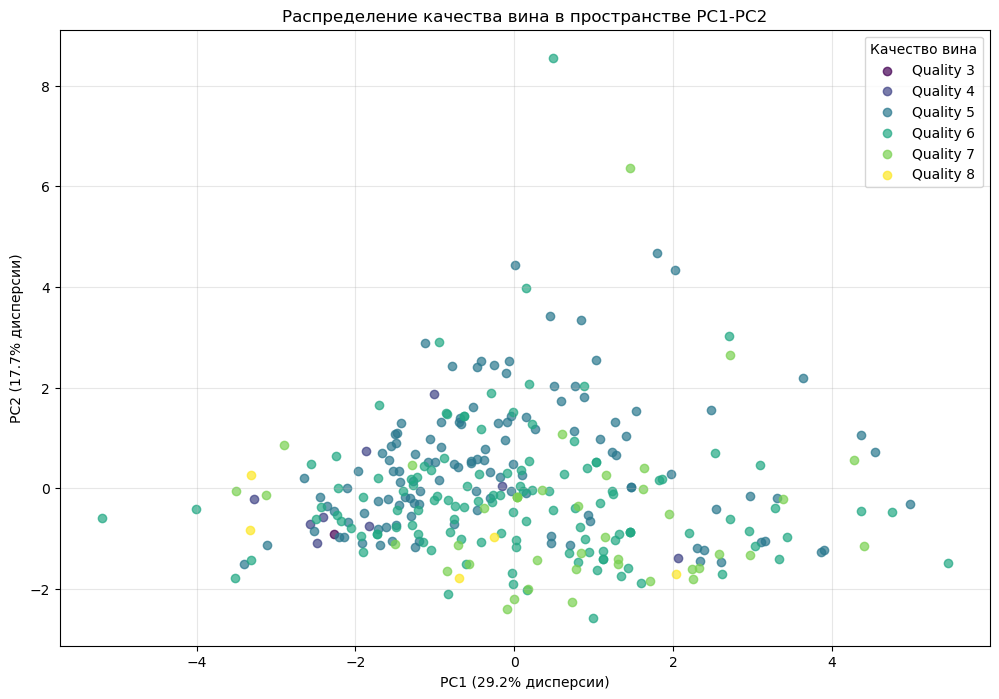

In [ ]:
pca = PCA(n_components=2)  # Указываем количество главных компонентов
wPCA = pca.fit_transform(wine)
# Создаем цветовую карту для дискретных значений
unique_qualities = np.unique(y)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_qualities)))

plt.figure(figsize=(12, 8))
for i, quality in enumerate(unique_qualities):
    mask = (y == quality)
    plt.scatter(wPCA[mask, 0], wPCA[mask, 1],
               c=[colors[i]], label=f'Quality {quality}', alpha=0.7)

plt.xlabel('PC1 (29.2% дисперсии)')
plt.ylabel('PC2 (17.7% дисперсии)')
plt.legend(title='Качество вина')
plt.title('Распределение качества вина в пространстве PC1-PC2')
plt.grid(True, alpha=0.3)
plt.show()



Как мы видим, разница почти не заметна. Обучим теперь ту же саму архитектуру, но используя только 5 главных компонент.

In [ ]:
X = (U @ S)[:, :5]
y = data['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Масштабирование данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Создание модели ИНС для многоклассовой классификации
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.1))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(num_classes, activation='softmax'))  # Динамическое количество классов

# Компиляция модели (ДОБАВЬ оптимизатор и метрики)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Обучение модели
history = model.fit(X_train, y_train, epochs=300, batch_size=32, validation_data=(X_test, y_test))

y_pred_prob = model.predict(X_test)
y_pred = y_pred_prob.argmax(axis=1)  # Берем класс с максимальной вероятностью
y_true = y_test.argmax(axis=1)

# Вычисление F1-меры
f1 = f1_score(y_true, y_pred, average='macro')
print(f'F1 Score: {f1:.4f}')

Epoch 1/300


C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.1875 - loss: 1.7822 - val_accuracy: 0.4167 - val_loss: 1.6540
Epoch 2/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4417 - loss: 1.6397 - val_accuracy: 0.4167 - val_loss: 1.5078
Epoch 3/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4500 - loss: 1.5141 - val_accuracy: 0.4333 - val_loss: 1.3658
Epoch 4/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4583 - loss: 1.3785 - val_accuracy: 0.4500 - val_loss: 1.2477
Epoch 5/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4708 - loss: 1.2872 - val_accuracy: 0.4833 - val_loss: 1.1681
Epoch 6/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5292 - loss: 1.1993 - val_accuracy: 0.5000 - val_loss: 1.1140
Epoch 7/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5792 - loss: 1.1159 - val_accuracy: 0.5167 - val_loss: 1.0884
Epoch 8/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5583 - loss: 1.0888 - val_accuracy: 0.5500 - val_loss: 1.0705
Epoch 9/3

Можно заметить, что точность понизилась, что может говорить о том, что наши данные являются линейно неразделимыми.

##2. Kernel PCA

###2.1 Краткая теория от Kernel PCA

Метод главных компонент неразрывно связан с сингулярным разложением благодаря следующему соотножению[6]:

T = UΣ
P = V

для центрированных матриц, где T - матрица счетов, P - матрица нагрузок.
Однако, классический метод главных компонент способен качественно работать только линейно разделимыми даннмы. В случае линейно-неразделимых данных предлагается воспользоваться ядерным методом главных компонент (Kernel PCA). Основной идеей нового метода является приведение исходной матрицы к виду ядерной матрицы, вычисляемой на основе заданного ядра:
$k(x_i,x_j) = <Ф(x_i),Ф(x_j)>$

###2.2 Практическая реализация

In [ ]:
def core(x, y, trick, sigma, deg): # Функция, задающая ядро. Можно выбрать линейное(результат будет как с классическим PCA), полиномиальное и RBF
    x = x.astype(np.float64)
    y = y.astype(np.float64)
    if trick == "poly":
        return (np.dot(x, y) + sigma) ** deg
    elif trick == "rbf":
        gamma = 1 / (2 * (sigma ** 2))
        return np.exp(- gamma * (norma(x - y) ** 2))
    elif trick == "lin":
        return np.dot(x, y)

In [ ]:
def kernel_matrix(matrix, sigma, deg, trick="lin"): # вычисление ядерной матрицы
    A = matrix.copy()
    m, n = A.shape
    K = np.empty((m, m))

    for i in range(m):
        for j in range(m):
            K[i, j] = core(A[i], A[j], trick, sigma, deg)
    return K

In [ ]:
def center_Kmatrix(matrix): # центрирование ядерной матрицы
    m, n = matrix.shape
    E = np.ones((n, n), dtype=float)
    E = E / n
    return matrix - E @ matrix - matrix @ E + E @ matrix @ E

In [ ]:
def kernelPCA(matrix, n_comp=2, trick="lin", sigma=1, deg=2):
    K = matrix.copy()
    K = kernel_matrix(K, sigma, deg, trick) # Вычисляем ядерную матрицу
    K = center_Kmatrix(K) # Центрируем

    U, S, V = SVD(K) # Вычисляем сингулярное разложение



    return U[:, :n_comp] @ np.diag(np.sqrt(S[:n_comp])) # Непосредственно возвращает массив главных компонент


Найдем теперь главные компоненты для нашего датасета с использованием различных ядер, и выведем результаты на двумерные графики:

In [ ]:
wineLin = kernelPCA(wine, n_comp=5, trick="lin")

In [ ]:
winePoly = kernelPCA(wine, n_comp=5, trick="poly", sigma=1, deg=10)

In [ ]:
wineRbf = kernelPCA(wine, n_comp=5, trick="rbf", sigma=5)

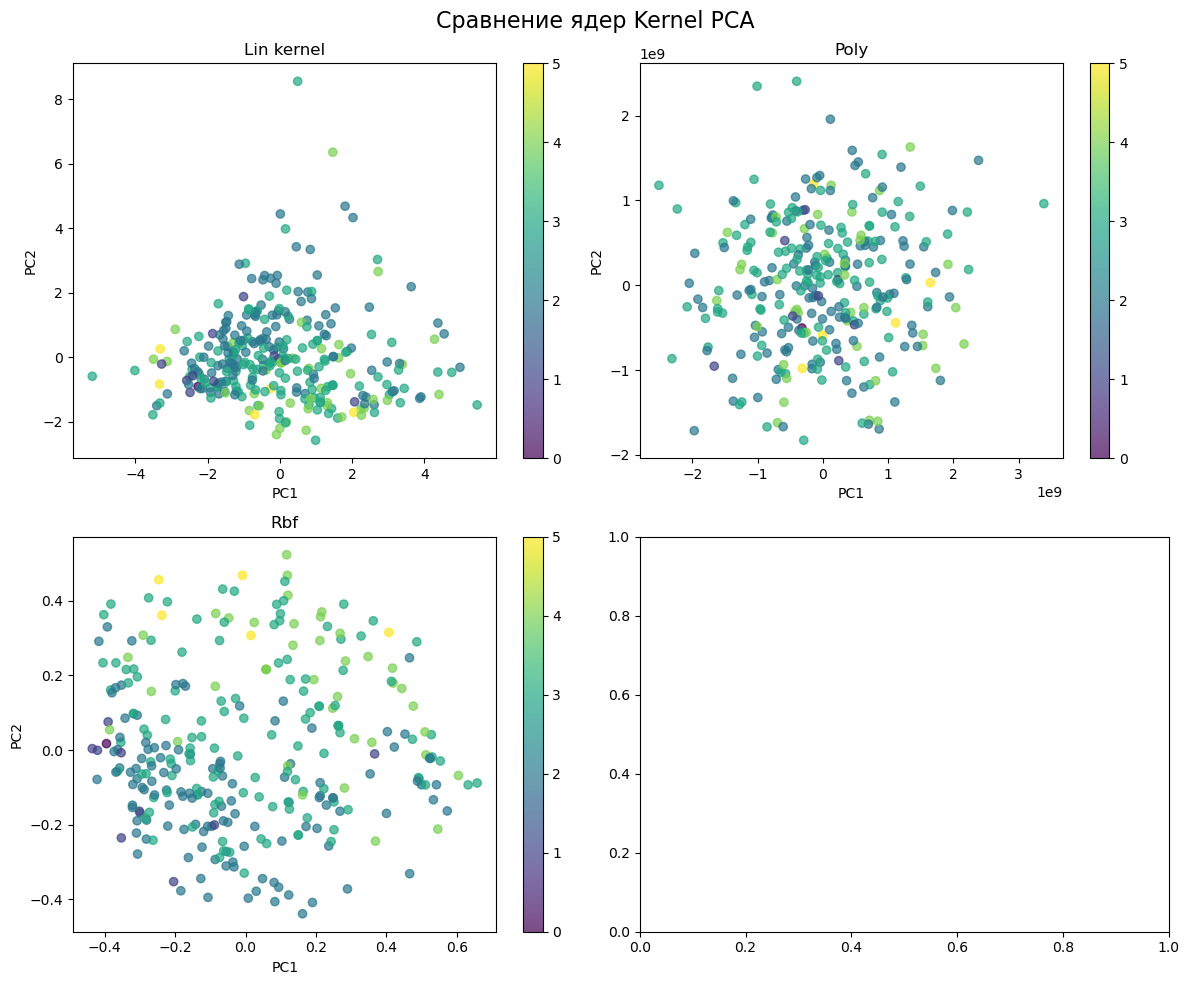

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Сравнение ядер Kernel PCA', fontsize=16)

# Linear PCA
scatter1 = axes[0, 0].scatter(wineLin[:, 0], wineLin[:, 1], c=y_encoded, cmap='viridis', alpha=0.7)
axes[0, 0].set_title('Lin kernel')
axes[0, 0].set_xlabel('PC1')
axes[0, 0].set_ylabel('PC2')
plt.colorbar(scatter1, ax=axes[0, 0])

# Kernel PCA - RBF
scatter2 = axes[0, 1].scatter(winePoly[:, 0], winePoly[:, 1], c=y_encoded, cmap='viridis', alpha=0.7)
axes[0, 1].set_title('Poly')
axes[0, 1].set_xlabel('PC1')
axes[0, 1].set_ylabel('PC2')
plt.colorbar(scatter2, ax=axes[0, 1])

# Kernel PCA - Polynomial
scatter3 = axes[1, 0].scatter(wineRbf[:, 0], wineRbf[:, 1], c=y_encoded, cmap='viridis', alpha=0.7)
axes[1, 0].set_title('Rbf')
axes[1, 0].set_xlabel('PC1')
axes[1, 0].set_ylabel('PC2')
plt.colorbar(scatter3, ax=axes[1, 0])


plt.tight_layout()
plt.show()

После подбора параметров можно заметить, что лучше всех с задачей справилось rbf ядро. Используем его для обучения новой модели.

In [ ]:
X = wineRbf
y = data['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Масштабирование данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Создание модели ИНС для многоклассовой классификации
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.1))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(num_classes, activation='softmax'))  # Динамическое количество классов

# Компиляция модели (ДОБАВЬ оптимизатор и метрики)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Обучение модели
history = model.fit(X_train, y_train, epochs=300, batch_size=32, validation_data=(X_test, y_test))

y_pred_prob = model.predict(X_test)
y_pred = y_pred_prob.argmax(axis=1)  # Берем класс с максимальной вероятностью
y_true = y_test.argmax(axis=1)

# Вычисление F1-меры
f1 = f1_score(y_true, y_pred, average='macro')
print(f'F1 Score: {f1:.4f}')

Epoch 1/300


C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.3750 - loss: 1.7040 - val_accuracy: 0.3667 - val_loss: 1.6792
Epoch 2/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3833 - loss: 1.5409 - val_accuracy: 0.4000 - val_loss: 1.5181
Epoch 3/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4125 - loss: 1.3817 - val_accuracy: 0.4167 - val_loss: 1.3548
Epoch 4/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4833 - loss: 1.2464 - val_accuracy: 0.4833 - val_loss: 1.2168
Epoch 5/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5208 - loss: 1.1607 - val_accuracy: 0.4667 - val_loss: 1.1273
Epoch 6/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5208 - loss: 1.0644 - val_accuracy: 0.4833 - val_loss: 1.0908
Epoch 7/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5333 - loss: 1.0443 - val_accuracy: 0.4833 - val_loss: 1.0739
Epoch 8/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5708 - loss: 0.9886 - val_accuracy: 0.4667 - val_loss: 1.0530
Epoch 9/30

##3. Вывод

В ходе лабораторной работы были реализованы и применены на практических рассчетах функции SVD (с применением QR алгоритма на основе отражений Хаусхолдера и CompactWY представлением) и KernelPCA для линейного, полиномиального и RBF ядер. Реализованные функции были проверены в сравнении с готовыми решениями и показали хорошо приближенный результат. Полученные результаты были применены для рассчета главных компонент исходного датасета и показали небольшое улучшение предсказательной способности модели.

##4. Список литературы



1. Коновалова, Е. И. Численные методы линейной алгебры : учебное пособие / Е. И. Коновалова, Л. В. Яблокова. — Самара : Изд-во самарского университета, 2022. — 152 с.
2. Численные методы линейной алгебры : лекция 6 [Электронный ресурс]. — URL: https://nla360.fmin.xyz/lectures/lecture-6/lecture-6.html (дата обращения: 01.11.2025).
3. Численные методы. Часть 1 : учебное пособие [Электронный ресурс]. — URL: https://mainfo.ru/content/files/2022/08/numeric-methods-part1.pdf (дата обращения: 01.11.2025).
4. Schreiber, R. A Storage-Efficient WY Representation for Products of Householder Transformations / R. Schreiber, C. Van Loan // SIAM Journal on Scientific and Statistical Computing. — 1989. — Vol. 10, № 1. — P. 53–57. — DOI: 10.1137/0910005.
5. Dunn, I. A parallel algorithm synthesis procedure for high-performance computer architectures / I. Dunn, G. Meyer // High Performance Computing Systems. — New York : Springer Science + Business Media, 2003. — P. 245–260.
6. Метод главных компонент [Электронный ресурс]. — URL: https://rcs.chemometrics.ru/books/Метод-главных-компонент.pdf (дата обращения: 01.11.2025).